# Simulation Tools - Project 1

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import assimulo.problem as apro
import assimulo.solvers as asol


Could not find cannot import name 'dopri5' from 'assimulo.lib' (/home/mak/miniconda3/envs/sim/lib/python3.11/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/home/mak/miniconda3/envs/sim/lib/python3.11/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/home/mak/miniconda3/envs/sim/lib/python3.11/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


---------------------------------------------------------------------

## Task 1

#### Define pendulum function

In [4]:
def elastic_pendulum(t: float = 0.0, x: np.ndarray = np.array([0.0, 0.0, 0.0, 0.0]), k: float = 1.0) -> np.ndarray:
    y1, y2, y3, y4 = x

    eps = 1e-12
    r = max(np.sqrt(y1*y1 + y2*y2), eps)

    lam = k * (r - 1.0) / r

    xvec = np.zeros_like(x)
    xvec[0] = y3
    xvec[1] = y4
    xvec[2] = -y1 * lam
    xvec[3] = -y2 * lam - 1.0
    return xvec


#### Setup values

In [163]:
k = 1.0
t0, tfinal = 0.0, 10.0
y0 = np.array([1.0, 0.0, 0.0, 1.5])


#### Wrap as an Assimulo Explicit Problem

In [164]:
spring_problem = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k=k), t0=t0, y0=y0)
spring_problem.name = r'Spring Pendulum with spring constant k={k}'
spring_problem.name = spring_problem.name.format(k=k)


#### CVode solver

In [165]:
spring_solver = asol.CVode(spring_problem)
spring_solver.reset()
# spring_solver.rtol = 1e-4
# spring_solver.atol = 1e-4
# spring_solver.discr = 'ADAMS'
# spring_solver.maxord = 8
t_sol, x_sol = spring_solver.simulate(100, 1000)


Final Run Statistics: Spring Pendulum with spring constant k=1.0 

 Number of steps                                 : 1444
 Number of function evaluations                  : 1786
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 100
 Number of error test failures                   : 69
 Number of nonlinear iterations                  : 1783
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.005529389000002993 seconds.


#### Plot the results

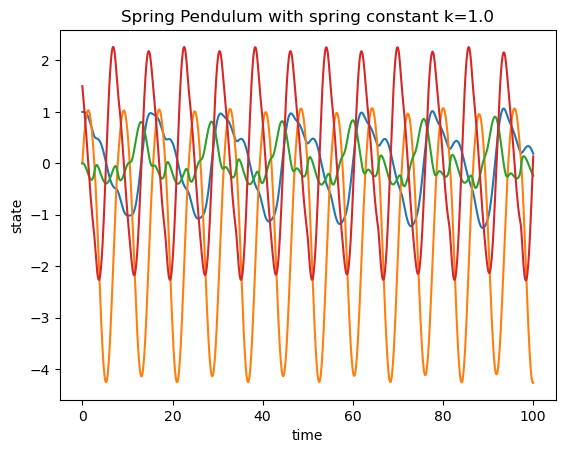

In [166]:
spring_solver.plot()


-------------------------------------------------------------------

## Task 2

#### Implement BDF4 solver using BDF2 template

In [92]:
from assimulo.explicit_ode import Explicit_ODE
from assimulo.ode import *
import scipy.linalg as SL

class BDF(Explicit_ODE):
    """
    BDF-4   (Example of how to set-up own integrators for Assimulo)
    """
    tol=1.e-8     
    maxit=1000     
    maxsteps=50000
    
    ALPHA_BDF2 = [3/2,  -2.0,   1/2]
    ALPHA_BDF3 = [11/6, -3.0,   3/2,  -1/3]
    ALPHA_BDF4 = [25/12, -4.0,  3.0,  -4/3, 1/4]

    avb_methods = ['EE', 'BDF2', 'BDF3', 'BDF4']

    def __init__(self, problem, methods=4, nonlin_solver='Newton', fixed_jacobian=False):
        self.nonlin_solver = nonlin_solver
        Explicit_ODE.__init__(self, problem) # Calls the base class
        
        #Solver options
        self.options["h"] = 0.01
        
        #Statistics
        self.statistics["nsteps"] = 0
        self.statistics["nfcns"] = 0

        self.init_methods = []
        self.methods = methods
        self.fixed_jacobian = fixed_jacobian
    
    def _set_h(self,h):
            self.options["h"] = float(h)

    def _get_h(self):
        return self.options["h"]
        
    h=property(_get_h,_set_h)
        
    def integrate(self, t, y, tf, opts):
        h = min(self.h, abs(tf - t))

        tres = [t]
        yres = [y.copy()]

        for i in range(self.maxsteps):
            if tres[-1] >= tf:
                break

            self.statistics["nsteps"] += 1
            h = min(self.h, abs(tf - tres[-1]))

            t_np1, y_np1 = self.step(tres, yres, h, i)

            tres.append(t_np1)
            yres.append(y_np1.copy())

        else:
            raise Explicit_ODE_Exception("Final time not reached within maximum number of steps")

        return ID_PY_OK, tres, yres
    
    def step(self, t, y, h, i):
        history = len(y)

        if self.methods >= 4 and history >= 4:
            alpha = self.ALPHA_BDF4

        elif self.methods >= 3 and history >= 3:
            if i == 2: self.init_methods.append('BDF3')
            alpha = self.ALPHA_BDF3

        elif self.methods >= 2 and history >= 2:
            if i == 1: self.init_methods.append('BDF2')
            alpha = self.ALPHA_BDF2

        else:
            if i == 0: self.init_methods.append('EE')
            return self.step_EE(t, y, h)
        
        return self.step_BDFk_fp(alpha, t, y, h)
    

    def get_jacobian(self, y_i, alpha, total, t_np1, h):
        f = self.problem.rhs
        eps = np.sqrt(np.finfo(float).eps)
        J = np.zeros((y_i.size, y_i.size))
        self.statistics["nfcns"] += 1

        for j in range(y_i.size):
            dz = eps*(1 + abs(y_i[j]))

            zp = y_i.copy()
            zm = y_i.copy()
            zp[j] += dz
            zm[j] -= dz

            gp = alpha[0]*zp + total - h*f(t_np1, zp)
            gm = alpha[0]*zm + total - h*f(t_np1, zm)
            self.statistics["nfcns"] += 2

            J[:, j] = (gp - gm) / (2*dz)

        return J
    

    def step_EE(self, t, y, h):
        """
        This calculates the next step in the integration with explicit Euler.
        """
        self.statistics["nfcns"] += 1
        t = t[-1]
        y = y[-1]

        f = self.problem.rhs
        return t + h, y + h*f(t, y) 
        

    def step_BDFk_fp(self, alpha, t, y, h):
        """
        This calculates the next step in the integration with BDF of order k using fixed-point iteration.
        """
        f = self.problem.rhs

        t_n = t[-1]
        t_np1 = t_n + h

        k = len(alpha) - 1 # order of BDF
        if len(y) < k: 
            raise Explicit_ODE_Exception(f"Not enough history for BDF{k}")


        total = 0.0    # collecting all terms of BDF
        for j in range(1, k + 1):
            total += alpha[j] * y[-j]
        y_i = y[-1].copy()    # initial point for nonlinear solver (solution at previous time step)

        if self.nonlin_solver == 'FixedPoint':
            for it in range(self.maxit):
                self.statistics["nfcns"] += 1
                y_ip1 = (-total + h * f(t_np1, y_i)) / alpha[0]
                if SL.norm(y_ip1 - y_i) < self.tol:
                    return t_np1, y_ip1
                
                y_i = y_ip1

            raise Explicit_ODE_Exception(f"{self.avb_methods[self.methods-1]} corrector did not converge in {self.maxit} iterations")
                
        elif self.nonlin_solver == 'Newton': 
            # freezing the Jacobian and forward difference - nearly a second faster and still good results -- compare this with analytical jacobian
            J = self.get_jacobian(y_i, alpha, total, t_np1, h)

            for it in range(self.maxit):
                g = alpha[0]*y_i + total - h*f(t_np1, y_i)
                self.statistics["nfcns"] += 1

                if not self.fixed_jacobian:
                    J = self.get_jacobian(y_i, alpha, total, t_np1, h)

                # Newton correction
                delta = SL.solve(J, -g)
                y_new = y_i + delta

                if SL.norm(delta) < self.tol*(1 + SL.norm(y_new)):
                    return t_np1, y_new

                y_i = y_new

            raise Explicit_ODE_Exception(f"BDF{k} Newton did not converge in {self.maxit} iterations")

        else:
            raise Explicit_ODE_Exception(f"Unknown nonlinear solver: {self.nonlin_solver}")

        #raise Explicit_ODE_Exception(f"BDF{k} corrector did not converge in {self.maxit} iterations")


            
    def print_statistics(self, verbose=NORMAL):
        self.log_message('Final Run Statistics            : {name} \n'.format(name=self.problem.name),        verbose)
        self.log_message(' Step-length                    : {stepsize} '.format(stepsize=self.options["h"]), verbose)
        self.log_message(' Number of Steps                : '+str(self.statistics["nsteps"]),          verbose)               
        self.log_message(' Number of Function Evaluations : '+str(self.statistics["nfcns"]),         verbose)
            
        self.log_message('\nSolver options:\n',                                    verbose)
        self.log_message(f' Solver            : {self.avb_methods[self.methods-1]}',                     verbose)
        self.log_message(f' Solver type       : {self.nonlin_solver}\n',                      verbose)
        self.log_message('Initialization methods used : ' + ', '.join(self.init_methods), verbose)


Final Run Statistics            : --- 

 Step-length                    : 0.01 
 Number of Steps                : 10000
 Number of Function Evaluations : 10000

Solver options:

 Solver            : EE
 Solver type       : Newton

Initialization methods used : EE
Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.043986103999941406 seconds.


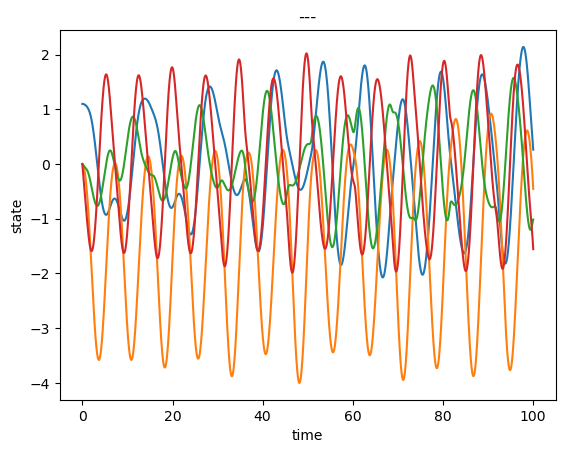

In [28]:
#Define an Assimulo problem
spring_problem = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k=1.0), t0=t0, y0=y0)

#Define an explicit solver
test_sim = BDF(spring_problem, methods=1, nonlin_solver='Newton') #Create a BDF solver
test_sim.fixed_jacobian = True
test_sim.h=0.01
t, y = test_sim.simulate(100)
test_sim.plot()
plt.show()


##










 Task 3

#### Define Assimulo problem for different k

Final Run Statistics            : Spring Pendulum with spring constant k=100 

 Step-length                    : 0.01 
 Number of Steps                : 10000
 Number of Function Evaluations : 119989

Solver options:

 Solver            : BDF4
 Solver type       : Newton

Initialization methods used : EE, BDF2, BDF3
Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 1.438023382999745 seconds.


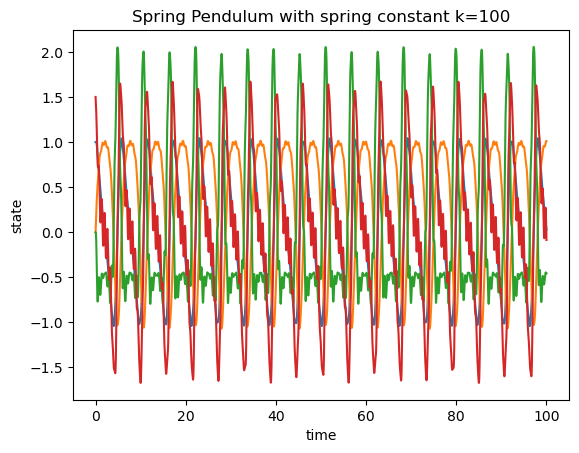

In [177]:
#Define an Assimulo problem
klist = [5, 5, 10]
k = 100
spring_problem = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k=k), t0=t0, y0=y0)
spring_problem.name = r'Spring Pendulum with spring constant k={k}'
spring_problem.name = spring_problem.name.format(k=k)

#Define an explicit solver
test_sim = BDF(spring_problem, nonlin_solver='Newton') #Create a BDF solver
test_sim.fixed_jacobian = True
t, y = test_sim.simulate(100)
test_sim.plot()
plt.show()


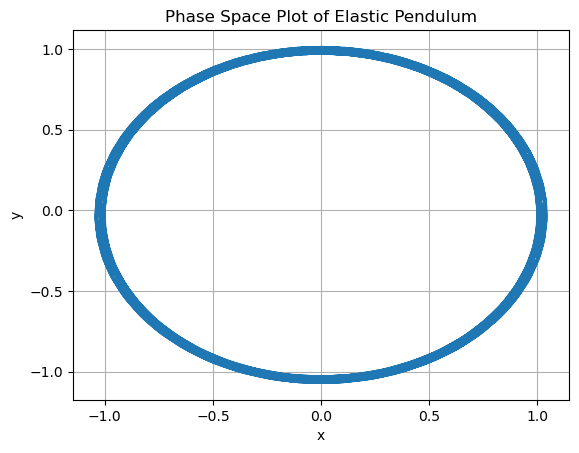

In [178]:
# plot y[0] vs y[1]
plt.plot(y[:,0], y[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Space Plot of Elastic Pendulum')
plt.grid()
plt.show()


-------------------------------------------------------------------------------------

#### Task 3 (and kind of task 4?) (cleaned up code and add wrappers to make analysis easier)

##### Analysis setup

In [137]:
t0, tfinal = 0.0, 10.0
y0 = np.array([1.5, 0.0, 0.0, 0.0])
k_values = [1, 10, 100, 1000, 2000]


In [142]:
# CVode solver wrapper
def run_cvode(k, y0, t0, tfinal, rtol=1e-10, atol=1e-12, ncp=2000, maxord=None):
    prob = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k), y0=y0, t0=t0)
    prob.name = r'Spring Pendulum with spring constant k={k} using CVode'
    prob.name = prob.name.format(k=k)
    
    solver = asol.CVode(prob)
    solver.rtol = rtol
    solver.atol = atol
    solver.maxord = maxord if maxord is not None else solver.maxord
    
    t, y = solver.simulate(tfinal, ncp=ncp)
    return np.asarray(t), np.asarray(y), solver.statistics


In [89]:
# BDF solver wrapper
def run_bdf(k, y0, t0, tfinal, h, methods, nonlin_solver, fixed_jacobian=False, ncp=2000):
    prob = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k), y0=y0, t0=t0)
    prob.name = r'Spring Pendulum with spring constant k={k} using BDF'
    prob.name = prob.name.format(k=k)
    
    solver = BDF(prob, methods=methods, nonlin_solver=nonlin_solver, fixed_jacobian=fixed_jacobian)
    solver.h = h
    solver.maxsteps = 500000

    try:
        t, y = solver.simulate(tfinal, ncp=ncp)
        t = np.asarray(t); y = np.asarray(y)
        ok = np.all(np.isfinite(y)) and np.max(np.abs(y)) < 1e6
        status = "ok" if ok else "blowup"
        return t, y, solver.statistics, status
    except Exception as e:
        return None, None, solver.statistics, f"fail: {type(e).__name__}"


In [58]:
# helper functions

def interp_ref(t_ref, y_ref, t):
    # componentwise linear interpolation
    yI = np.vstack([np.interp(t, t_ref, y_ref[:,i]) for i in range(y_ref.shape[1])]).T
    return yI

def position_error(t, y, t_ref, y_ref):
    yI = interp_ref(t_ref, y_ref, t)
    pos = y[:, :2]
    posI = yI[:, :2]
    e = np.linalg.norm(pos - posI, axis=1)
    return float(np.max(e))


In [154]:
def task3_analysis(k_values, h, y0, t0, tfinal, rtol=1e-10, atol=1e-12, maxord=None, cvode_only=False):
    rows = []
    for k in k_values:
        # reference
        t_ref, y_ref, st_ref = run_cvode(k, y0, t0, tfinal, rtol=rtol, atol=atol, maxord=maxord)

        # methods
        if cvode_only:
            configs = [
                ("CVode", dict()),
            ]
            rows.append(dict(k=k, h=np.nan, method="CVode", status="ok",
                            max_pos_err=0.0, nsteps=st_ref["nsteps"], nfcns=st_ref["nfcns"]))
        else:
            configs = [
                ("EE",   dict(methods=1, nonlin_solver="Newton")),
                ("BDF2-FP", dict(methods=2, nonlin_solver="FixedPoint")),
                ("BDF4-Newton", dict(methods=4, nonlin_solver="Newton", fixed_jacobian=False)),    # can play around with this to see function evaluations
            ]

            for name, cfg in configs:
                t, y, st, status = run_bdf(k, y0, t0, tfinal, h=h, **cfg)
                if t is None:
                    err = np.nan
                    nsteps = st["nsteps"]
                    nfcns  = st["nfcns"]
                else:
                    err = position_error(t, y, t_ref, y_ref)
                    nsteps = st["nsteps"]
                    nfcns  = st["nfcns"]

                rows.append(dict(k=k, h=h, method=name, status=status,
                                max_pos_err=err, nsteps=nsteps, nfcns=nfcns))
    return rows


##### Run analysis (produce dataframe table)

In [156]:
import pandas as pd
rows = task3_analysis(k_values=k_values, h=0.01, y0=y0, t0=t0, tfinal=10.0, cvode_only=False)
bdf_df = pd.DataFrame(rows)
display(bdf_df)


Final Run Statistics: Spring Pendulum with spring constant k=1 using CVode 

 Number of steps                                 : 738
 Number of function evaluations                  : 787
 Number of Jacobian evaluations                  : 13
 Number of function eval. due to Jacobian eval.  : 52
 Number of error test failures                   : 6
 Number of nonlinear iterations                  : 784
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.003800622999733605 seconds.
Final Run Statistics            : Spring Pendulum with spring constant k=1 using BDF 

 Step-length                    : 0.01 
 Number of Steps                : 1001
 Number of Function Evalua

,k,h,method,status,max_pos_err,nsteps,nfcns
0,1,0.01,EE,ok,1.626308e-01,1001,1001
1,1,0.01,BDF2-FP,ok,6.736854e-04,1001,4023
2,1,0.01,BDF4-Newton,ok,1.282238e-03,1001,34471
3,10,0.01,EE,ok,7.748913e-01,1001,1001
4,10,0.01,BDF2-FP,ok,4.075108e-03,1001,5142
5,10,0.01,BDF4-Newton,ok,9.754073e-03,1001,38751
6,100,0.01,EE,ok,4.246110e+01,1001,1001
7,100,0.01,BDF2-FP,ok,1.715961e-01,1001,7862
8,100,0.01,BDF4-Newton,ok,5.691499e-02,1001,38981
9,1000,0.01,EE,blowup,1.364599e+20,1001,1001


In [115]:
def funcvk(df):
    methods = df['method'].unique()
    plt.figure()
    for method in methods:
        df_method = df[df['method'] == method]
        plt.plot(df_method['k'], df_method['nfcns'], marker='o', label=method)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Spring constant k')
    plt.ylabel('Number of function evaluations')
    plt.title('Function Evaluations vs Spring Constant')
    plt.legend()
    plt.grid()
    plt.show()


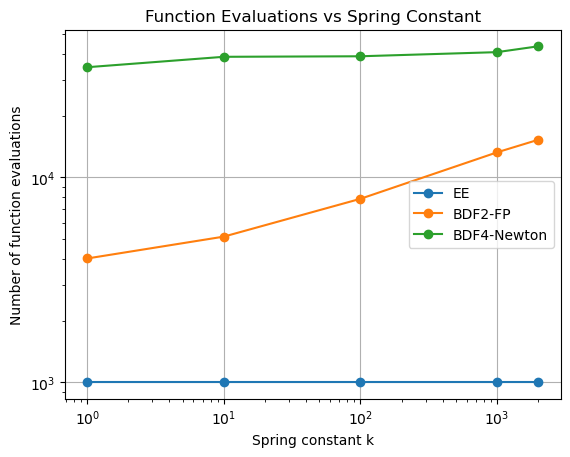

In [139]:
# plot function evaluations vs k for each method
funcvk(bdf_df)


In [124]:
def errvk(df):
    methods = df['method'].unique()
    plt.figure()
    for method in methods:
        df_method = df[df['method'] == method]
        plt.plot(df_method['k'], df_method['max_pos_err'], marker='o', label=method)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Spring constant k')
    plt.ylabel('Maximum position error')
    plt.title('Maximum Position Error vs Spring Constant')
    plt.legend()
    plt.grid()
    plt.show()


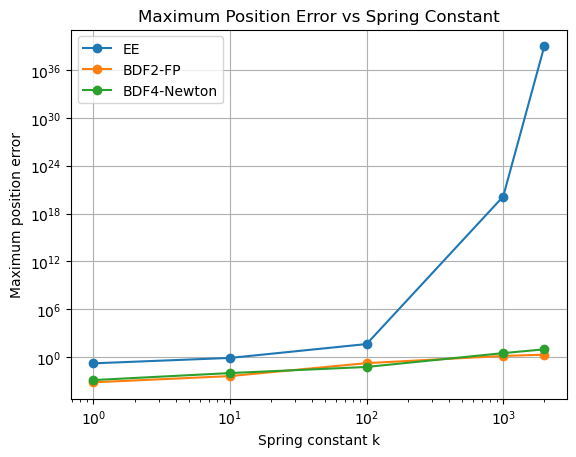

In [140]:
errvk(bdf_df)


#### # TODO: make sure this uses the data from task3_analysis so it doesn't have to recompute everything

In [151]:
def plot_for_k(k, h, y0, t0, tfinal, rtol=1e-10, atol=1e-12, maxord=None, cvode_only=False):
    t_ref, y_ref, _ = run_cvode(k, y0, t0, tfinal, rtol=rtol, atol=atol, maxord=maxord)

    if cvode_only:
        runs = {}
    
    else:
        runs = {
            "EE": run_bdf(k, y0, t0, tfinal, h=h, methods=1, nonlin_solver="Newton"),
            "BDF2-FP": run_bdf(k, y0, t0, tfinal, h=h, methods=2, nonlin_solver="FixedPoint"),
            "BDF4-Newton": run_bdf(k, y0, t0, tfinal, h=h, methods=4, nonlin_solver="Newton"),
        }

    # trajectory
    plt.figure()
    plt.plot(y_ref[:,0], y_ref[:,1], label="CVODE ref", linewidth=2)
    for name,(t,y,st,status) in runs.items():
        if y is not None:
            plt.plot(y[:,0], y[:,1], label=f"{name} ({status})")
    plt.xlabel("y1"); plt.ylabel("y2")
    plt.title(f"Trajectory, k={k}, h={h}")
    plt.legend()
    plt.show()

    # radius vs time
    plt.figure()
    plt.plot(t_ref, np.hypot(y_ref[:,0], y_ref[:,1]), label="CVODE ref", linewidth=2)
    for name,(t,y,st,status) in runs.items():
        if y is not None:
            plt.plot(t, np.hypot(y[:,0], y[:,1]), label=f"{name} ({status})")
    plt.xlabel("t"); plt.ylabel("r(t)")
    plt.title(f"Radius (spring stretch), k={k}, h={h}")
    plt.legend()
    plt.show()


#### Just run this code to get analysis plots:

Final Run Statistics: Spring Pendulum with spring constant k=1 using CVode 

 Number of steps                                 : 738
 Number of function evaluations                  : 787
 Number of Jacobian evaluations                  : 13
 Number of function eval. due to Jacobian eval.  : 52
 Number of error test failures                   : 6
 Number of nonlinear iterations                  : 784
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.0035371819994907128 seconds.
Final Run Statistics            : Spring Pendulum with spring constant k=1 using BDF 

 Step-length                    : 0.01 
 Number of Steps                : 1001
 Number of Function Evalu

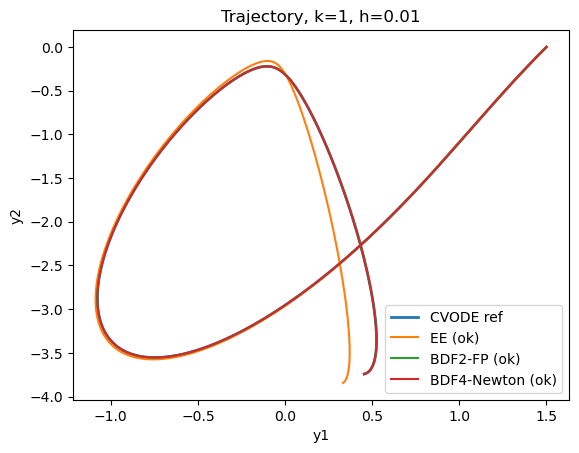

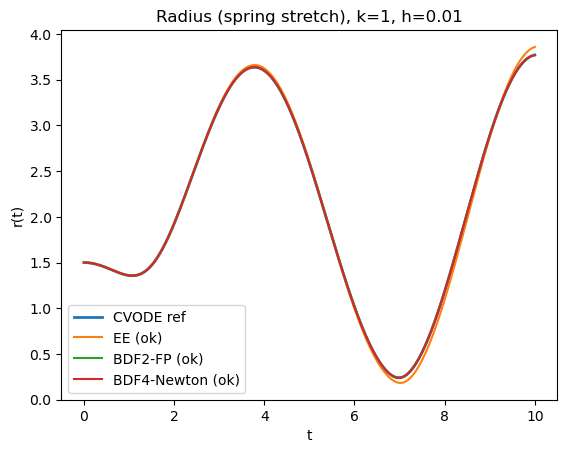

Final Run Statistics: Spring Pendulum with spring constant k=10 using CVode 

 Number of steps                                 : 1713
 Number of function evaluations                  : 1844
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 116
 Number of error test failures                   : 9
 Number of nonlinear iterations                  : 1841
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.007171319000008225 seconds.
Final Run Statistics            : Spring Pendulum with spring constant k=10 using BDF 

 Step-length                    : 0.01 
 Number of Steps                : 1001
 Number of Function 

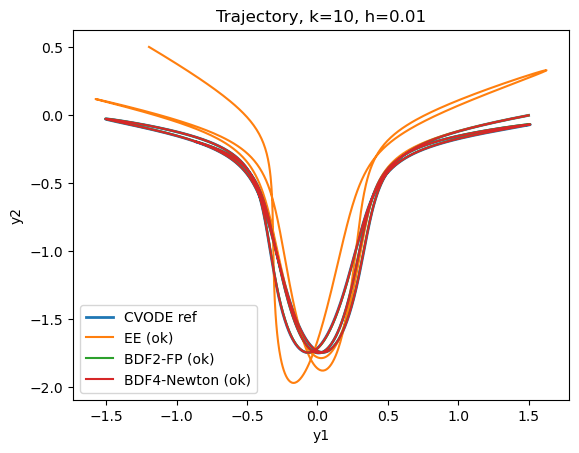

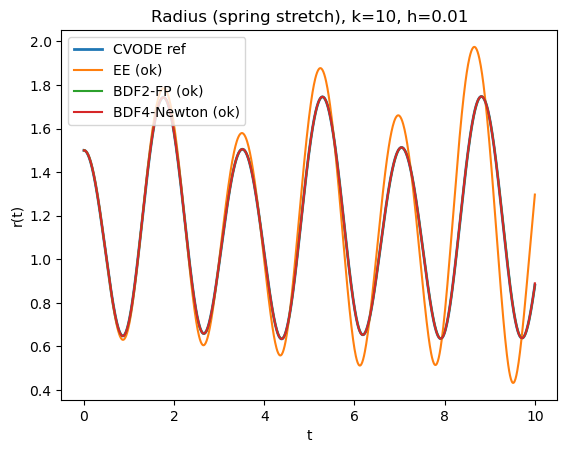

Final Run Statistics: Spring Pendulum with spring constant k=100 using CVode 

 Number of steps                                 : 5319
 Number of function evaluations                  : 5745
 Number of Jacobian evaluations                  : 90
 Number of function eval. due to Jacobian eval.  : 360
 Number of error test failures                   : 60
 Number of nonlinear iterations                  : 5742
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.017655949000072724 seconds.
Final Run Statistics            : Spring Pendulum with spring constant k=100 using BDF 

 Step-length                    : 0.01 
 Number of Steps                : 1001
 Number of Functi

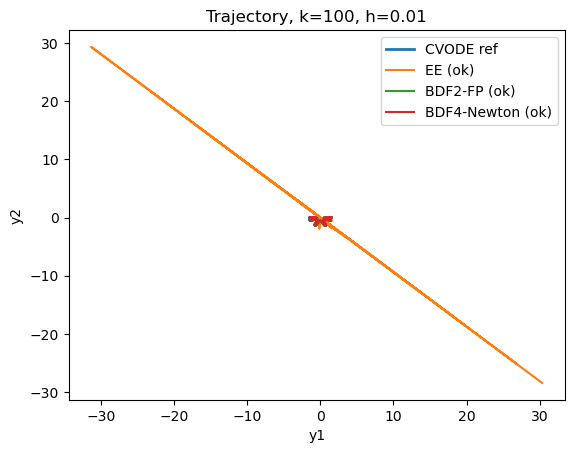

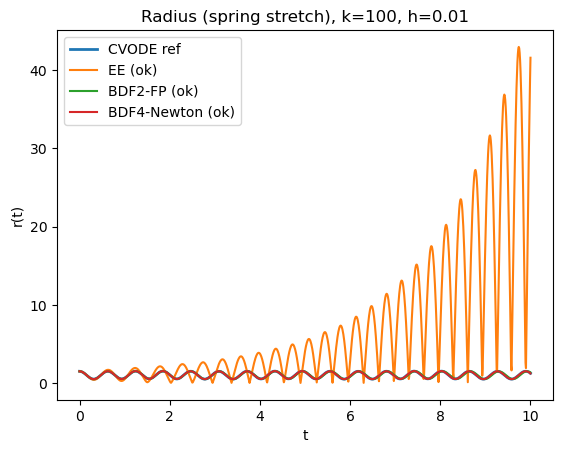

Final Run Statistics: Spring Pendulum with spring constant k=1000 using CVode 

 Number of steps                                 : 15441
 Number of function evaluations                  : 16771
 Number of Jacobian evaluations                  : 258
 Number of function eval. due to Jacobian eval.  : 1032
 Number of error test failures                   : 192
 Number of nonlinear iterations                  : 16768
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.047261909000553715 seconds.
Final Run Statistics            : Spring Pendulum with spring constant k=1000 using BDF 

 Step-length                    : 0.01 
 Number of Steps                : 1001
 Number o

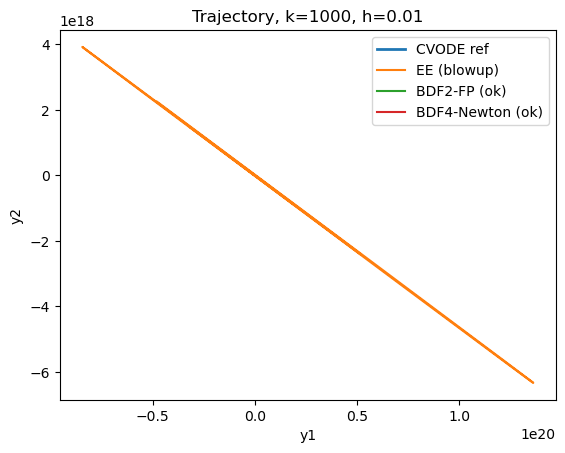

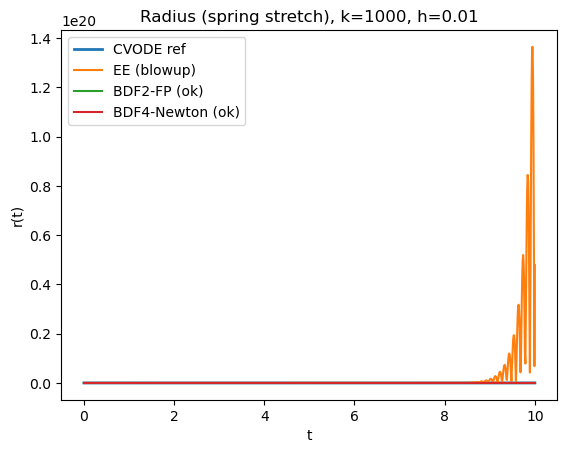

Final Run Statistics: Spring Pendulum with spring constant k=2000 using CVode 

 Number of steps                                 : 21441
 Number of function evaluations                  : 23227
 Number of Jacobian evaluations                  : 359
 Number of function eval. due to Jacobian eval.  : 1436
 Number of error test failures                   : 260
 Number of nonlinear iterations                  : 23225
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.06408408399965992 seconds.
Final Run Statistics            : Spring Pendulum with spring constant k=2000 using BDF 

 Step-length                    : 0.01 
 Number of Steps                : 1001
 Number of

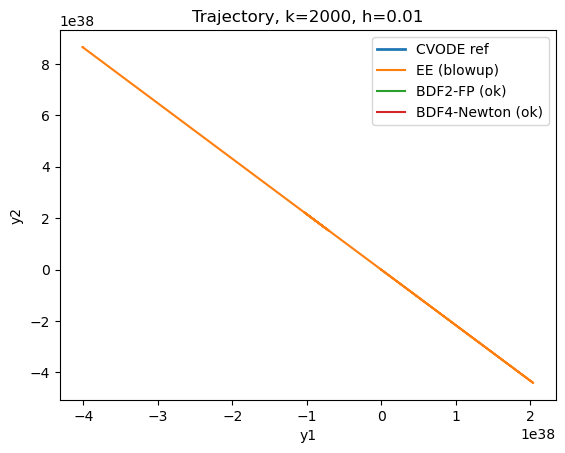

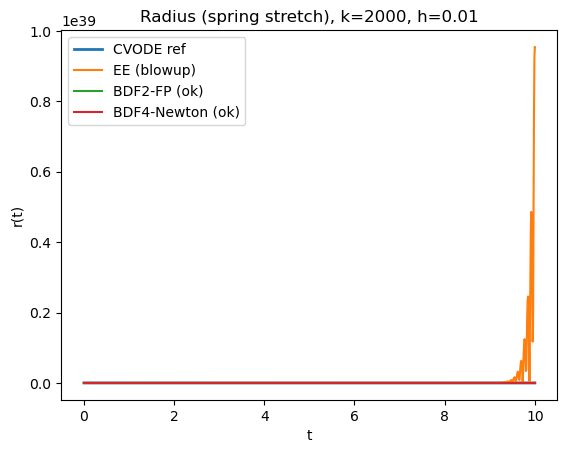

In [141]:
for k in k_values:
    plot_for_k(k=k, h=0.01, y0=y0, t0=t0, tfinal=10.0, cvode_only=False)


#### Task 4 (only CVode even though we kinda already have it incorporated in the analysis above)

In [122]:
rows = task3_analysis(k_values=k_values, h=0.01, y0=y0, t0=t0, tfinal=10.0, cvode_only=True) # cvode_true will always say 'ok' since that is our reference
cvode_df = pd.DataFrame(rows)
display(cvode_df)


Final Run Statistics: Spring Pendulum with spring constant k=1 using CVode 

 Number of steps                                 : 738
 Number of function evaluations                  : 787
 Number of Jacobian evaluations                  : 13
 Number of function eval. due to Jacobian eval.  : 52
 Number of error test failures                   : 6
 Number of nonlinear iterations                  : 784
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.003371269000126631 seconds.
Final Run Statistics: Spring Pendulum with spring constant k=10 using CVode 

 Number of steps                                 : 1713
 Number of function evaluations                  : 1844
 N

,k,h,method,status,max_pos_err,nsteps,nfcns
0,1,NaN,CVode,ok,0.0,738,787
1,10,NaN,CVode,ok,0.0,1713,1844
2,100,NaN,CVode,ok,0.0,5319,5745
3,1000,NaN,CVode,ok,0.0,15441,16771
4,2000,NaN,CVode,ok,0.0,21441,23227


#### Plot function evaluations vs k

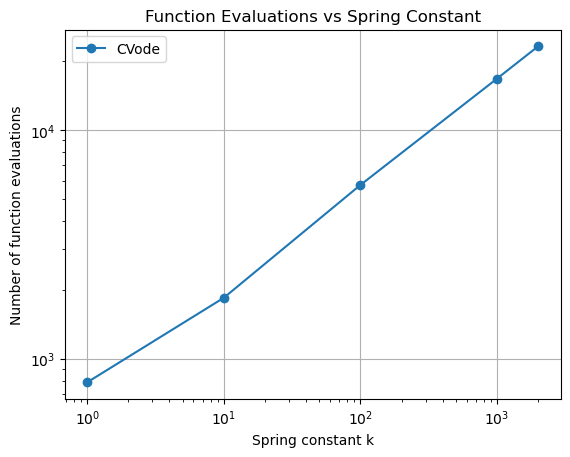

In [132]:
funcvk(cvode_df)


Final Run Statistics: Spring Pendulum with spring constant k=1 using CVode 

 Number of steps                                 : 690
 Number of function evaluations                  : 754
 Number of Jacobian evaluations                  : 12
 Number of function eval. due to Jacobian eval.  : 48
 Number of error test failures                   : 7
 Number of nonlinear iterations                  : 751
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.003732099999979255 seconds.


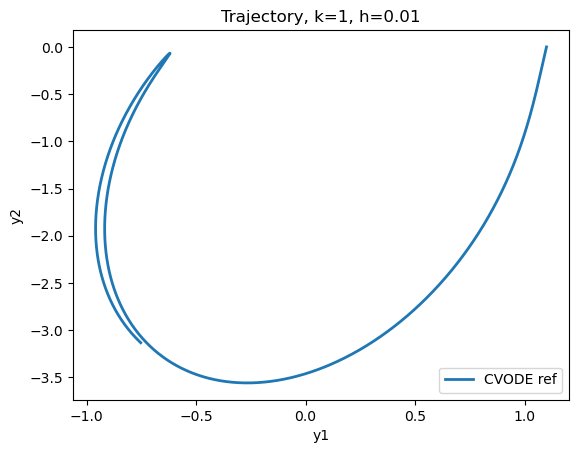

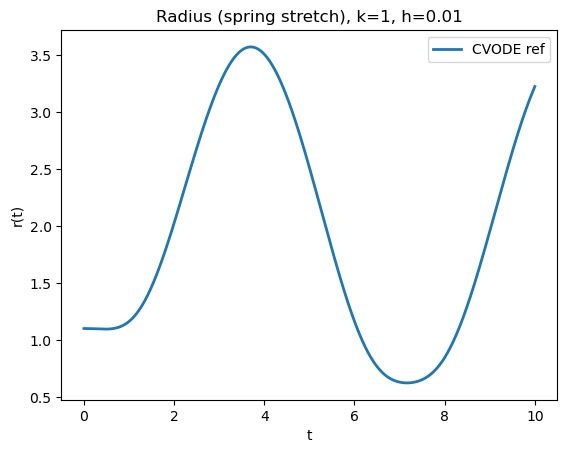

Final Run Statistics: Spring Pendulum with spring constant k=10 using CVode 

 Number of steps                                 : 1585
 Number of function evaluations                  : 1661
 Number of Jacobian evaluations                  : 27
 Number of function eval. due to Jacobian eval.  : 108
 Number of error test failures                   : 6
 Number of nonlinear iterations                  : 1658
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.005329159000211803 seconds.


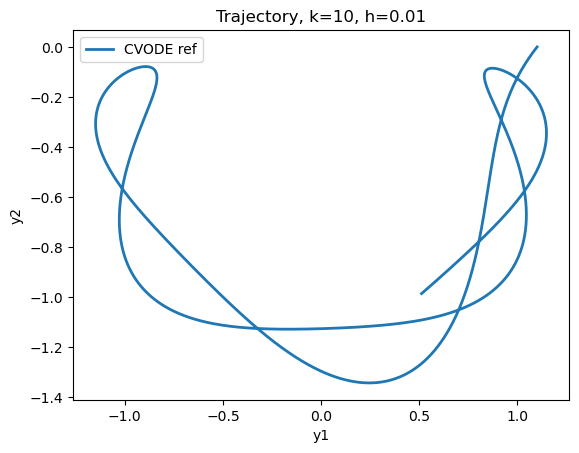

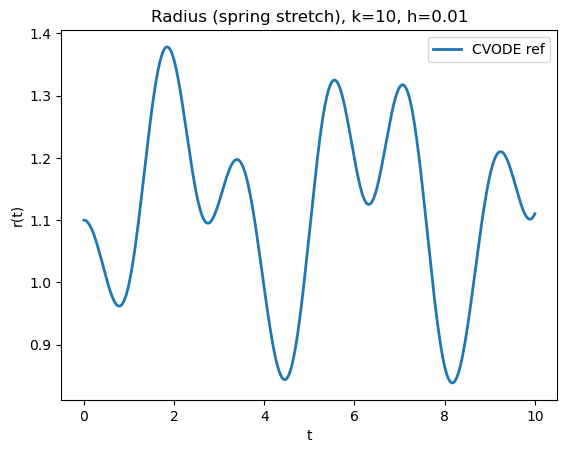

Final Run Statistics: Spring Pendulum with spring constant k=100 using CVode 

 Number of steps                                 : 4544
 Number of function evaluations                  : 4775
 Number of Jacobian evaluations                  : 76
 Number of function eval. due to Jacobian eval.  : 304
 Number of error test failures                   : 30
 Number of nonlinear iterations                  : 4772
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.013830509000399616 seconds.


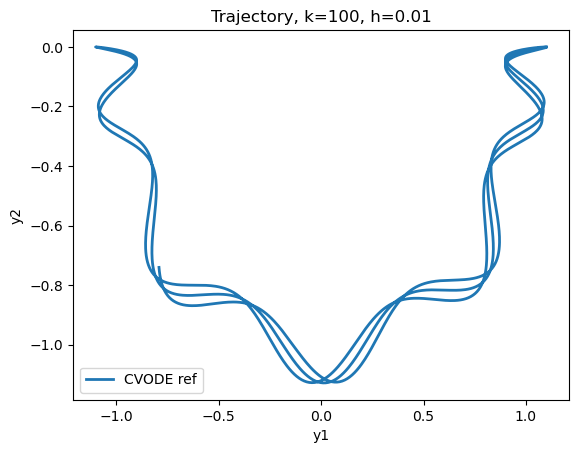

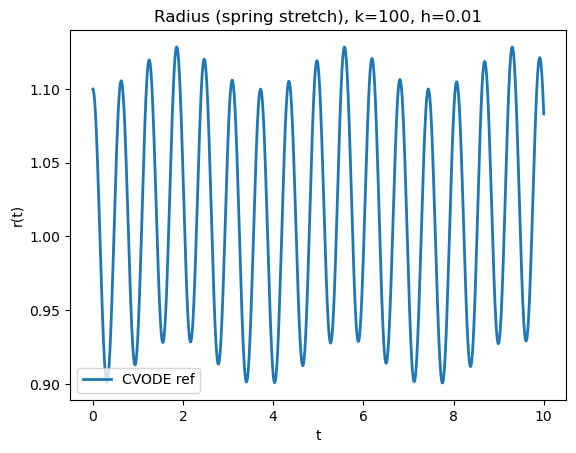

Final Run Statistics: Spring Pendulum with spring constant k=1000 using CVode 

 Number of steps                                 : 13856
 Number of function evaluations                  : 14857
 Number of Jacobian evaluations                  : 231
 Number of function eval. due to Jacobian eval.  : 924
 Number of error test failures                   : 134
 Number of nonlinear iterations                  : 14854
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-12
 Tolerances (relative)    : 1e-10

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.0401203279998299 seconds.


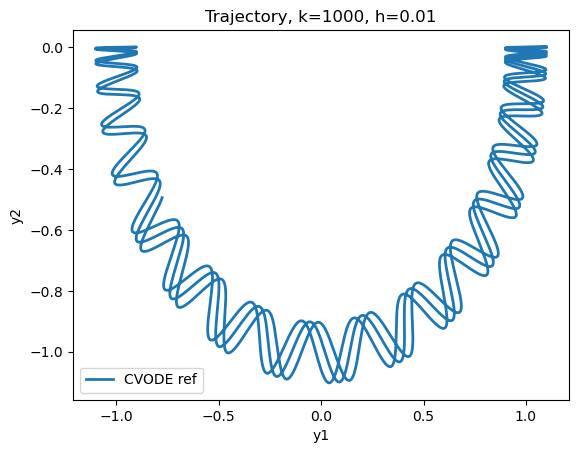

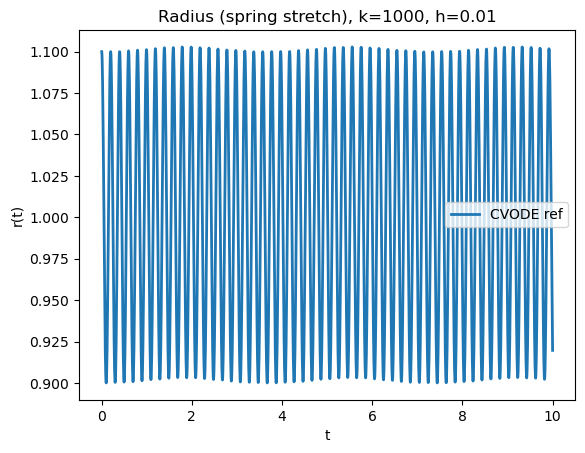

In [53]:
# can play around with ATOL, RTOL, MAXORD here:

for k in [1, 10, 100, 1000]: 
    plot_for_k(k=k, h=0.01, y0=y0, t0=t0, tfinal=10.0, cvode_only=True)


#### TODO (maybe): extra analysis comparing approximated and fixed Jacobian with exact Jacobian